# TFIM N = 18 or 24 SA vs Tcut (hx 変えて何本かプロット) updated

In [2]:
import qutip as qt
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import lru_cache
import requests
# 通知設定
DISCORD_WEBHOOK_URL = "https://discord.com/api/webhooks/1439055708988375082/6iiXA8J_3Bn1RPWZ8XmPfmfSJp_PkGdaIzt495Ao2fbu_a09VnMJpxmrnSyfN4Wtyc7T"
def notify_discord(message: str):
    payload = {"content": message}
    try:
        r = requests.post(DISCORD_WEBHOOK_URL, json=payload, timeout=5)
        r.raise_for_status()
        print("✅ Discord 通知送信 OK")
    except Exception as e:
        print("⚠ Discord 通知に失敗:", e)

# グラフ設定
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')
mpl.rcParams.update({
    "axes.labelsize": 18,   # 軸ラベル
    "xtick.labelsize": 16,  # 目盛り数字
    "ytick.labelsize": 16,
    "lines.linewidth": 2.2, # 線の太さ
    "axes.titlesize": 16,
})

def inward_ticks(ax, major_len=7, minor_len=4, width=1.2):
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, right=True, length=major_len, width=width)
    ax.tick_params(which='minor', length=minor_len, width=width)

markers = ['o', '^', 's', 'D', 'x']
OUTDIR = Path("../charts/tfim2")

# データ保存
DATADIR = Path("../data/tfim")

# データ読み込み(あれば)
# fname = DATADIR / "SA_vs_Tcut_N{N}_hx{hxstamp}_.npz" 

# dat = np.load(fname)

# N_list  = dat["N"]   # shape (nN,)
# hx_list = dat["hx_list"]  # shape (nHx,)
# Tcut_list = dat["Tcut"]
# EE      = dat["EE"]       # shape (nN, nHx)

In [ ]:
# ========= キャッシュ付きヘルパ =========

@lru_cache(maxsize=None)
def get_ops(N):
    """Nだけで決まる演算子たち"""
    cut_pos = N // 2 - 1
    sx, sz = qt.sigmax(), qt.sigmaz()
    I2 = qt.qeye(2)

    def op_at(i, op):
        return qt.tensor([op if k == i else I2 for k in range(N)])

    Sx = [op_at(i, sx) for i in range(N)]
    Sz = [op_at(i, sz) for i in range(N)]

    def H_exchange(i):
        return Sz[i] * Sz[i+1]

    Hcut_unit   = H_exchange(cut_pos)
    Hex_rest_unit = sum(H_exchange(i) for i in range(N-1) if i != cut_pos)
    Hhx_unit    = sum(Sx[i] for i in range(N))

    left_sites = list(range(N//2))
    return Hcut_unit, Hex_rest_unit, Hhx_unit, left_sites


@lru_cache(maxsize=None)
def get_psi0(N, J, hx):
    """(N, J, hx)で決まる初期基底状態"""
    Hcut_unit, Hex_rest_unit, Hhx_unit, _ = get_ops(N)
    H_full = -J * (Hcut_unit + Hex_rest_unit) - hx * Hhx_unit
    _, psi0 = H_full.groundstate(sparse=True)
    return psi0

# シミュレーション関数
# ========= メイン: Tcut ごとの時間発展 =========


def simulate(N, J, hx, Tcut):
    Hcut_unit, Hex_rest_unit, Hhx_unit, left_sites = get_ops(N)
    psi0 = get_psi0(N, J, hx)

    # H(t) = H_static + (-J * Hcut_unit) * ramp(t)
    H_static = -J * Hex_rest_unit - hx * Hhx_unit

    def ramp(t, T_cut):
        if T_cut == 0.0:
            # 瞬時切断：t<=0で1, t>0で0
            return 1.0 if t <= 0.0 else 0.0
        if t <= 0.0:
            return 1.0
        if t >= T_cut:
            return 0.0
        return 1.0 - t / T_cut

    Ht = [H_static, [-J * Hcut_unit, lambda t, args: ramp(t, Tcut)]]

    # ---- Tcut=0 は積分せず即時評価 ----
    if Tcut <= 0.0:
        rhoL = qt.ptrace(psi0, left_sites)
        return float(qt.entropy_vn(rhoL, base=2))

    # ---- 長時間を区間分割して 2点出力でつないでいく ----
    # 例: 1000刻み（Tcut=10000なら10区間）
    seg_len = 1000.0
    nseg = max(1, int(np.ceil(Tcut / seg_len)))
    grid = np.linspace(0.0, Tcut, nseg + 1)

    # 剛性が強い/臨界近傍を想定して bdf、必要なら adams に変更
    opts = qt.Options(
        method='bdf',          # 剛性に強い。速さ優先なら 'adams'
        rtol=1e-6,
        atol=1e-8,
        nsteps=200_000,        # 内部最大ステップ数の上限を増やす
        max_step=(Tcut/nseg)/200.0,  # 各区間長/200 を目安（安定しないなら小さく）
        store_states=True,     # 2点出力なのでメモリ負担は僅少
        progress_bar=None,
    )

    psi = psi0
    for k in range(nseg):
        t0, t1 = float(grid[k]), float(grid[k+1])
        # 各区間は tlist=[t0, t1] の2点出力（終端だけ使う）
        res = qt.sesolve(Ht, psi, [t0, t1], e_ops=[], options=opts)
        psi = res.states[-1]

    # 終端で部分トレース→エントロピー
    rhoL = qt.ptrace(psi, left_sites)
    return float(qt.entropy_vn(rhoL, base=2))


In [ ]:
N_list     = [12]
hx_list    = [0.0, 0.4, 0.5, 0.6, 0.7, 1.0]
Tcut_list  = np.linspace(0.0, 10000.0, 21)  # 0,1,2,...,10
J          = 1.0
hxstamp    = "-".join(map(str, hx_list))

# マーカーが未定義だったので用意
markers = ["o", "s", "D", "^", "v", "<", ">", "P", "X", "*"]

for i, N in enumerate(N_list):
    print(f"N is {N}")
    fig4, ax4 = plt.subplots(figsize=(6.9, 4.6))

    # 保存用に全 hx の曲線をまとめる (shape: [len(hx_list), len(Tcut_list)])
    EE_all = np.empty((len(hx_list), len(Tcut_list)), dtype=float)

    for j, hx in enumerate(hx_list):
        print(f"start simulation N = {N}, hx = {hx}")
        resi_EE = []
        for Tcut in Tcut_list:
            val = simulate(N=N, J=J, hx=hx, Tcut=Tcut)
            resi_EE.append(val)
            print(f"Tcut is {Tcut}")
            if Tcut == 0.0:
                print(f"resiEE is {val} when Tcut is 0")

        resi_EE = np.asarray(resi_EE, dtype=float)
        EE_all[j, :] = resi_EE

        mk = markers[j % len(markers)]
        ax4.plot(
            Tcut_list, resi_EE,
            marker=mk, markersize=6.0,
            label=fr"$h_x={hx:g}$",
            linewidth=2.2
        )

    inward_ticks(ax4)
    ax4.set_xlim(0.0, 10000.0)
    ax4.set_xlabel(r"$T_{\rm cut}$", fontsize=24)

    # 0.96-1.01 に固定していたが、外れる可能性もあるのでデータに合わせて少しマージンをとる
    ymin = min(0.96, EE_all.min() - 0.01)
    ymax = max(1.01, EE_all.max() + 0.01)
    ax4.set_ylim(ymin, ymax)

    ax4.set_ylabel(r"$S_A(t=T_{\rm cut})$", fontsize=24)
    ax4.yaxis.set_major_locator(MultipleLocator(0.01))
    ax4.yaxis.set_minor_locator(MultipleLocator(0.005))
    ax4.xaxis.set_major_locator(MultipleLocator(1000))
    ax4.xaxis.set_minor_locator(MultipleLocator(500))
    ax4.legend(frameon=False, ncol=2)

    print(f"sim 4 - {N} done")

    # # 先に保存してから show する方が安全
    # pdf_path = OUTDIR / f"SA_vs_Tcut_N{N}_hx{hxstamp}.pdf"
    # fig4.savefig(pdf_path, bbox_inches="tight", dpi=300)
    plt.show()

    # # .npz は .pdf と別ファイル名にする（拡張子ミス修正）＋ 補助情報も保存
    # npz_path = DATADIR / f"SA_vs_Tcut_N{N}_hx{hxstamp}.npz"
    # np.savez(
    #     npz_path,
    #     N=N,
    #     J=J,
    #     hx_list=np.array(hx_list, dtype=float),
    #     Tcut_list=np.array(Tcut_list, dtype=float),
    #     SA=EE_all,  # shape: [len(hx_list), len(Tcut_list)]
    #     note="SA(t=Tcut) curves for each hx"
    # )

    notify_discord(message=f"sim N = {N} is done (saved {pdf_path.name}, {npz_path.name})")


 N is 4
hx is 0.5
 Tcut is 0.0
 Tcut is 10.0
 Tcut is 20.0
 Tcut is 30.0
 Tcut is 40.0
 Tcut is 50.0
 Tcut is 60.0
 Tcut is 70.0
 Tcut is 80.0
 Tcut is 90.0
 Tcut is 100.0
tau is 10.0
sim 3 done


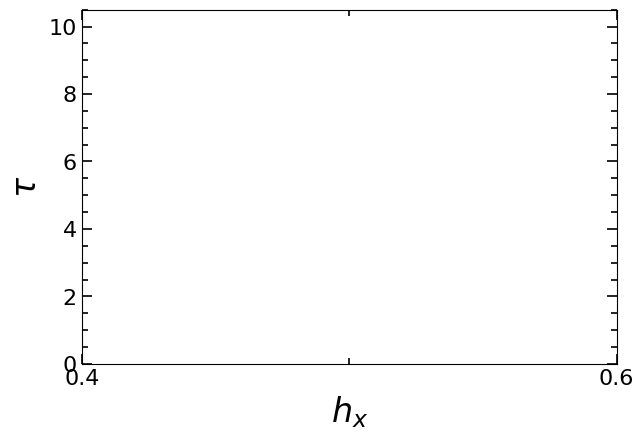

In [22]:
# 想定 : N_list = リスト, hx_list = リスト
# グラフ : (tau_list vs hx_list (len(N_list)本) × 1 
# 本番
# N_list = [4, 6, 8, 10]
# hx_list = np.linspace(0.1, 0.5, 21) 
# テスト
hx_list = [0.5]
N_list = [4]
Tcut_list = np.linspace(0.0, 100.0, 11)

# 0.1
# Tcut_list = np.linspace(0.0, 100000.0, 11)
# 0.2
# Tcut_list = np.linspace(0.0, 10000.0, 11) 
# 0.3
# Tcut_list = np.linspace(0.0, 1000.0, 11) 
# 0.4
# Tcut_list = np.linspace(0.0, 100.0, 11) 
# 0.5
# Tcut_list = np.linspace(0.0, 10.0, 11) 


fig3, ax3 = plt.subplots(figsize=(6.9, 4.6))
tau_max = 0.0
for i, N in enumerate(N_list):
    tau_list = []
    mk = markers[i % len(markers)]
    print(f" N is {N}")
    for j, hx in enumerate(hx_list):
        resi_EE = []
        print(f"hx is {hx}")
        for Tcut in Tcut_list:
            resi_EE.append(simulate(N=N, J=J, hx=hx, Tcut=Tcut))
            print(f" Tcut is {Tcut}")
        resi_EE = np.asarray(resi_EE)

        # SA(t=0)*0.5となる緩和時間を探す
        thr = 0.5 * resi_EE[0]
        relax = resi_EE < thr
        if relax.any():
            k = np.where(relax)[0][0]
            T50 = Tcut_list[k]
            tau_list.append(T50)
            print(f"tau is {T50}")
        else:
            tau_list.append(np.nan)

    if np.isfinite(tau_list).any():
        tau_max = max(tau_max, np.nanmax(tau_list))
    # ax3.plot(hx_list, tau_list, marker=mk, markersize=6.0, label=fr"$N={N:g}$", linewidth=2.2)
inward_ticks(ax3)
ax3.set_xlim(np.asarray(hx_list).min() - 0.1, np.asarray(hx_list).max() + 0.1)
ax3.set_xlabel(r"$h_x$", fontsize=24)
ax3.set_ylim(0.0, 1.05*tau_max if tau_max > 0 else 1.0)
ax3.set_ylabel(r"$\tau$", fontsize=24)        
ax3.xaxis.set_major_locator(MultipleLocator(0.2))
ax3.xaxis.set_minor_locator(MultipleLocator(0.1))
# ax3.legend(frameon=False)
print(f"sim 3 done")
plt.show()
# fig3.savefig(OUTDIR / f"tau_vs_hx_N{nstamp}.pdf", bbox_inches="tight", dpi=300)

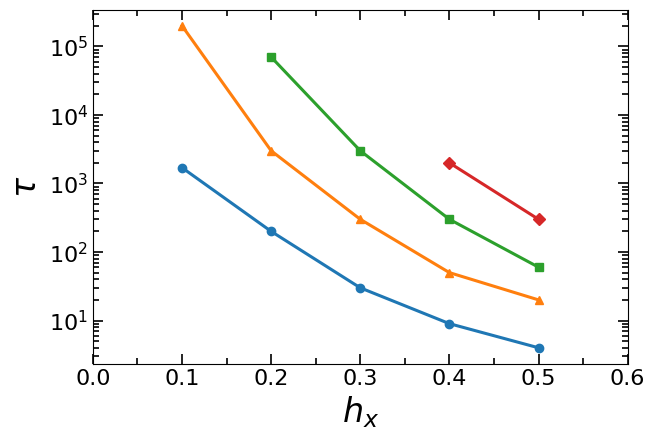

In [23]:
N_list = [4, 6, 8, 10]
hx_list = [0.1, 0.2, 0.3, 0.4, 0.5]
tau_list = [[1700, 200, 30,9,4], [200000, 3000, 300, 50, 20], [np.nan, 70000, 3000, 300, 60], [np.nan, np.nan, np.nan, 2000, 300]]

fig3, ax3 = plt.subplots(figsize=(6.9, 4.6))
for i, N in enumerate(N_list):
    mk = markers[i % len(markers)]
    ax3.plot(hx_list, tau_list[i], marker=mk, markersize=6.0, label=fr"$N={N:g}$", linewidth=2.2)

inward_ticks(ax3)
ax3.set_xlim(np.asarray(hx_list).min() - 0.1, np.asarray(hx_list).max() + 0.1)
ax3.set_xlabel(r"$h_x$", fontsize=24)
ax3.set_xscale('linear')
ax3.set_yscale('log')
ax3.set_ylabel(r"$\tau$", fontsize=24)        
ax3.xaxis.set_major_locator(MultipleLocator(0.1))
ax3.xaxis.set_minor_locator(MultipleLocator(0.05))
plt.show()
nstamp = '-'.join(map(str, N_list))
fig3.savefig(OUTDIR / f"tau_vs_hx_N{nstamp}.pdf", bbox_inches="tight", dpi=300)